# Person Segmentation Netowork

### Import necessary python lib

- set ImageFile.LOAD_TRUNCATED_IMAGES = True to avoid warinings while training. 
- data module contains all the image generator module functions for training

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import segmentation_models as sm
import sys
sys.path.append("..")
from seg_net.data import *
import keras

## Set Model Params

In [6]:
INPUT_SHAPE = (512,512,3) #(768,768,3)
NUM_CLASS = 1
BACKBONE = 'vgg16'
MODEL_NAME = 'Unet'
LOSS_METRICS = 'BCE_ACC_IOU'
MODEL_PATH = '/media/new_hdd2/seg_net/results/Models/Models'
ACTIVATION = 'sigmoid'

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}'.format(BACKBONE,
                                              MODEL_NAME,
                                              LOSS_METRICS,
                                              NUM_CLASS,
                                              ACTIVATION,
                                              INPUT_SHAPE[0])
keras_filename = '{}.hdf5'.format(model_fname)

## Build Model

In [7]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                  classes=NUM_CLASS,
                  activation=ACTIVATION,
                  input_shape = INPUT_SHAPE)

In [8]:
model.compile('sgd', loss=sm.losses.bce_dice_loss, metrics=['accuracy',sm.metrics.iou_score])
#model.compile('Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile('sgd', loss='mean_squared_error', metrics=['accuracy',sm.metrics.iou_score])

In [7]:
#model.load_weights(os.path.join(MODEL_PATH,keras_filename))

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Create Train and validation Image generators , keras callbacks to save model, learning rate scheduler and tensorboard monitoring.

In [14]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(1,'../data/raw/train','images','annotations',
                        data_gen_args,save_to_dir = None,
                        target_size = INPUT_SHAPE[:2],
                        imgNorm="divide" , 
                        binary = False,
                        num_class = NUM_CLASS, 
                        multiclass = False)

'''valGene = validationGenerator(1,'../data/raw/val','images','annotations',
                                save_to_dir = None,
                                target_size = INPUT_SHAPE[:2],
                                imgNorm="divide" , 
                                binary = False,
                                num_class = NUM_CLASS, 
                                multiclass = False)'''

model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH,keras_filename), 
                                                   monitor='loss',
                                                   verbose=1, 
                                                   save_best_only=True)

#tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

lr_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)

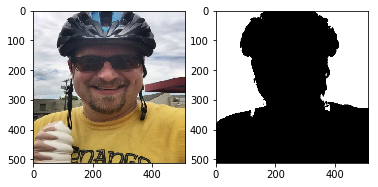

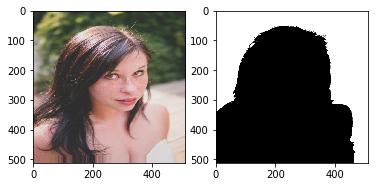

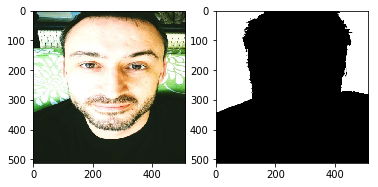

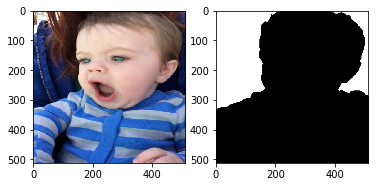

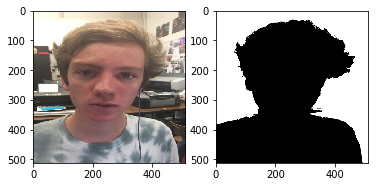

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(5):
    inp,otp = next(myGene)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inp[0,:,:,:])
    #axarr[1].imshow(otp.argmax(axis=-1)[0,:,:], cmap='Greys',  interpolation='nearest')
    axarr[1].imshow(np.squeeze(otp[0]), cmap='Greys',  interpolation='nearest')

## Train Model

In [16]:
model.fit_generator(myGene,steps_per_epoch=3000,epochs=50,
                    #validation_data=valGene, validation_steps=100,
                    callbacks=[model_checkpoint,lr_cb],
                    initial_epoch=0)

Epoch 1/50
Found 1603 images belonging to 1 classes.
Found 1603 images belonging to 1 classes.
3000/3000 [==============================] - 270s 90ms/step - loss: 0.2698 - acc: 0.9099 - iou_score: 0.8566

Epoch 00001: loss improved from inf to 0.26979, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5
Epoch 2/50
3000/3000 [==============================] - 243s 81ms/step - loss: 0.1333 - acc: 0.9460 - iou_score: 0.9298

Epoch 00002: loss improved from 0.26979 to 0.13334, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5
Epoch 3/50
3000/3000 [==============================] - 246s 82ms/step - loss: 0.1018 - acc: 0.9530 - iou_score: 0.9458

Epoch 00003: loss improved from 0.13334 to 0.10175, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5
Epoch 4/50
3000/3000 [==============================] - 246s 82ms/step 

Epoch 30/50
3000/3000 [==============================] - 248s 83ms/step - loss: 0.0305 - acc: 0.9668 - iou_score: 0.9822

Epoch 00030: loss improved from 0.03124 to 0.03046, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5
Epoch 31/50
3000/3000 [==============================] - 249s 83ms/step - loss: 0.0302 - acc: 0.9669 - iou_score: 0.9824

Epoch 00031: loss improved from 0.03046 to 0.03019, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5
Epoch 32/50
3000/3000 [==============================] - 250s 83ms/step - loss: 0.0296 - acc: 0.9670 - iou_score: 0.9827

Epoch 00032: loss improved from 0.03019 to 0.02956, saving model to /media/new_hdd2/seg_net/results/Models/Models/mobilenetv2_Unet_BCE_ACC_IOU_1_sigmoid_512.hdf5
Epoch 33/50
3000/3000 [==============================] - 249s 83ms/step - loss: 0.0297 - acc: 0.9669 - iou_score: 0.9827

Epoch 00033: loss did not 

## Test Model

In [17]:
import skimage
import glob
import os
import numpy as np
from keras.preprocessing import image
import cv2
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    img_ = preprocess_input(img_, imgNorm="divide")
    images.append(img)
    #outs.append(np.squeeze(model.predict(img_)).argmax(axis=-1))
    outs.append(np.squeeze(model.predict(img_)))

/home/avantariml/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/avantariml/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


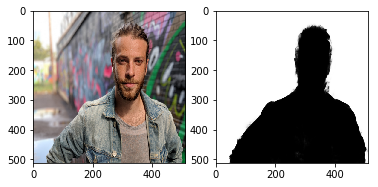

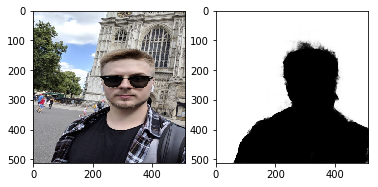

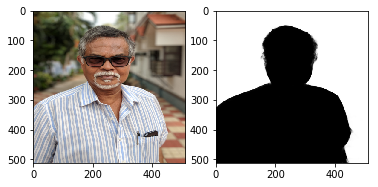

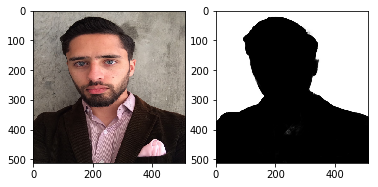

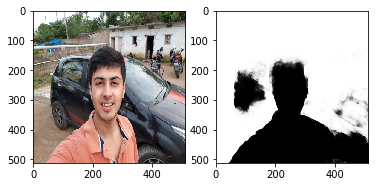

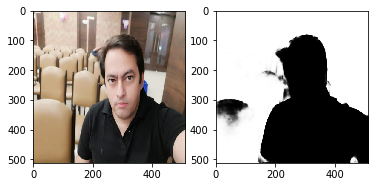

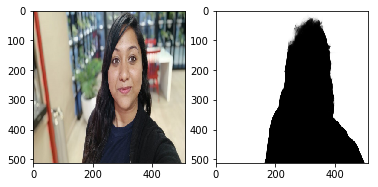

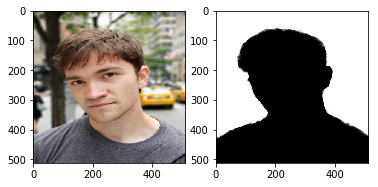

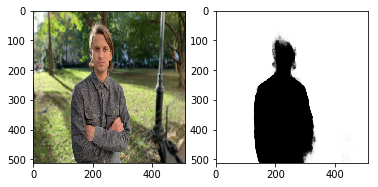

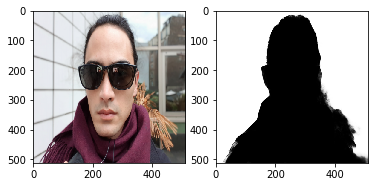

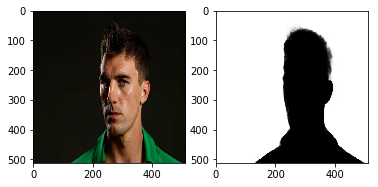

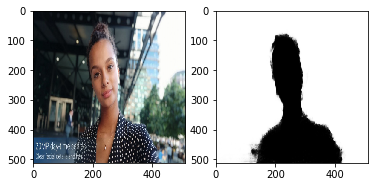

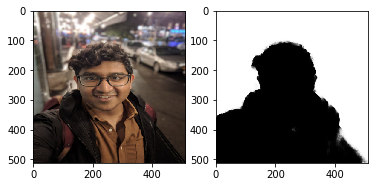

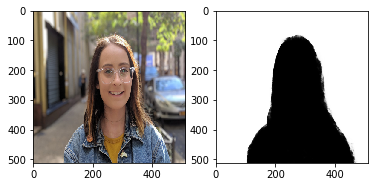

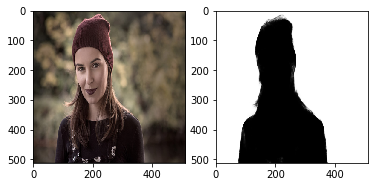

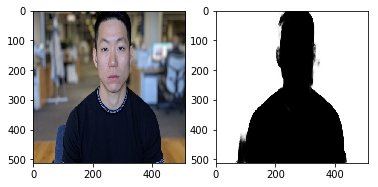

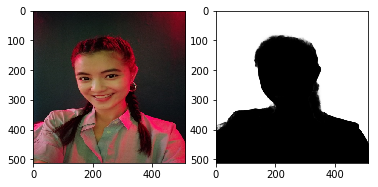

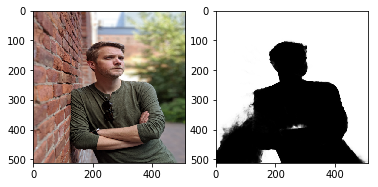

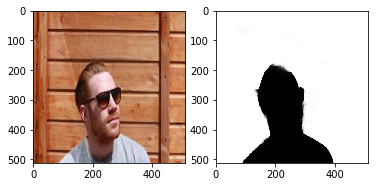

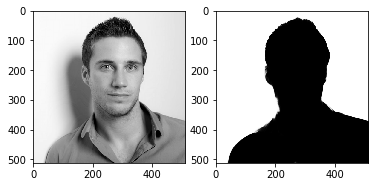

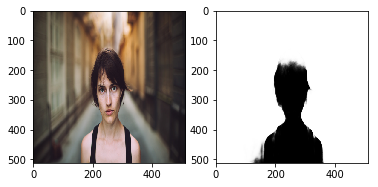

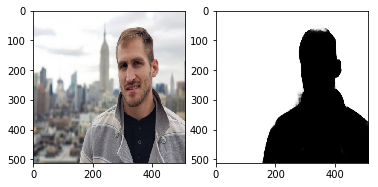

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,otp.shape,anti_aliasing=True))
    axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

/home/avantariml/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


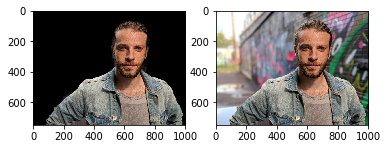

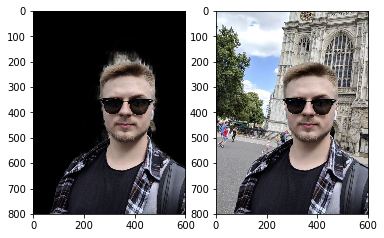

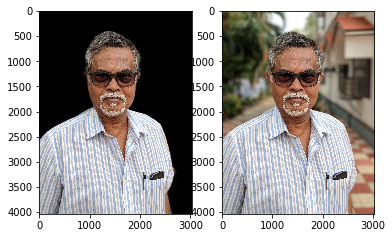

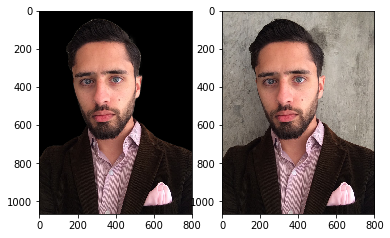

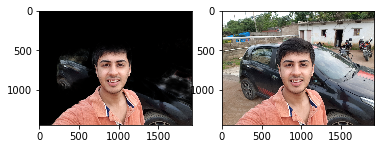

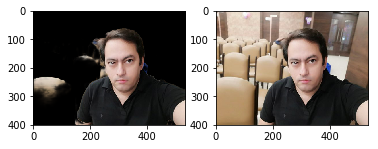

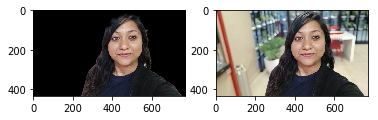

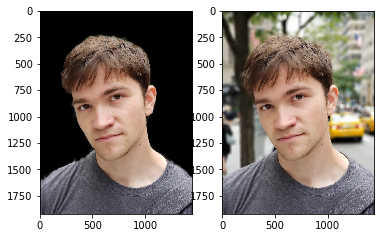

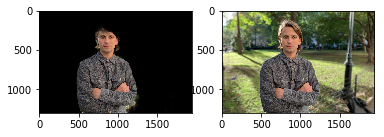

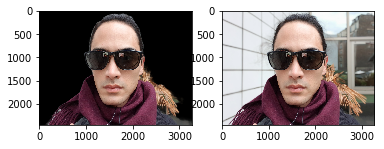

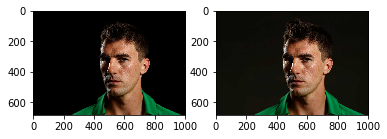

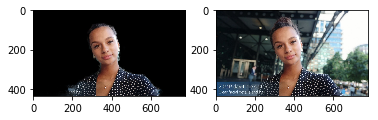

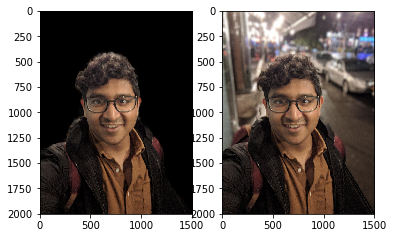

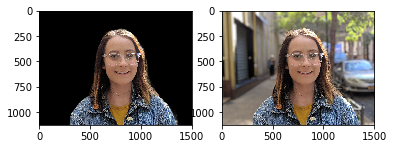

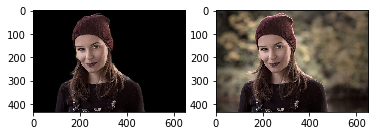

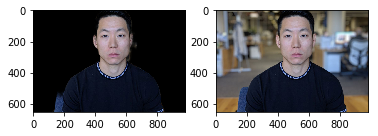

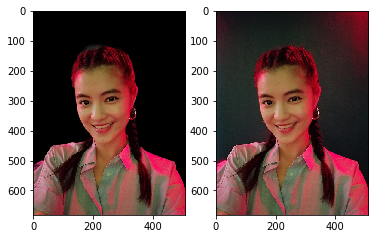

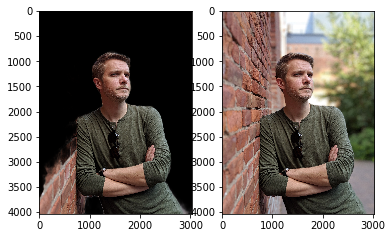

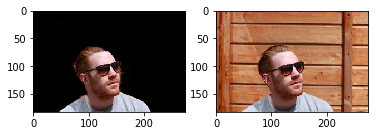

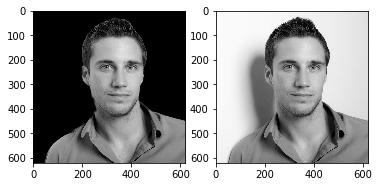

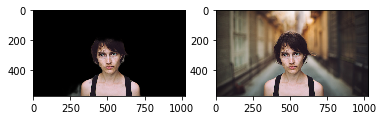

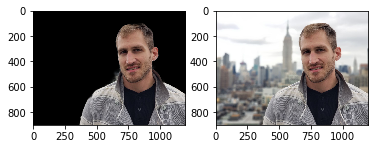

In [19]:
for inp,otp in zip(images,outs):
    mask = skimage.transform.resize(otp,inp.shape[:2],preserve_range=True)
    #mask = cv2.resize(otp,inp.shape[:2])
    im = np.copy(inp)
    #im[mask<0.3]=0
    #im[mask==0]=0
    im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(im)
    axarr[1].imshow(inp)

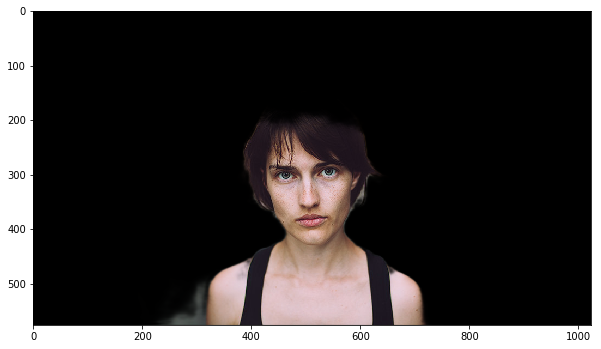

In [39]:
import random
i = random.choice(range(0,22))
im = np.copy(images[i])
mask = skimage.transform.resize(outs[i],im.shape[:2],preserve_range=True)
#mask = cv2.resize(outs[i],im.shape[:2])
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
#im[mask<0.3]=0
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)